# Reinforcement Learning with Human Feedback (RLHF)

RLHF is a new paradigm in reinforcement learning where the agent learns from human feedback. The feedback can be in the form of rewards, demonstrations, or corrections. The agent can be a human, a machine, or a combination of both. The goal is to learn a policy that maximizes the reward while minimizing the feedback. It is the way that ChatGPT was developed.

The general workflow of LLM training:
1. Model PreTraining
2. Model Supervised Fine-Tuning (SFT) * Converting next token prediction to chat response
3. Model Alignment (PPO/DPO) * Alignment of models to not swear, be polite, etc.

References:

[Reinforcement Learning from Human Feedback explained with math derivations and the PyTorch code](https://www.youtube.com/watch?v=qGyFrqc34yc&list=WL&index=8&ab_channel=UmarJamil)

[PPO paper: Schulman, J., Wolski, F., Dhariwal, P., Radford, A. and Klimov, O., 2017. Proximal policy optimization algorithms. arXiv preprint arXiv:1707.06347.](https://arxiv.org/abs/1707.06347)

[InstructGPT paper: Ouyang, L., Wu, J., Jiang, X., Almeida, D., Wainwright, C., Mishkin, P., Zhang, C., Agarwal, S., Slama, K., Ray, A. and Schulman, J., 2022. Training language models to follow instructions with human feedback. Advances in Neural Information Processing Systems, 35, pp.27730-27744.](https://arxiv.org/abs/2203.02155)

[Generalized Advantage Estimation paper: Schulman, J., Moritz, P., Levine, S., Jordan, M. and Abbeel, P., 2015. High-dimensional continuous control using generalized advantage estimation. arXiv preprint arXiv:1506.02438.](https://arxiv.org/abs/1506.02438)


[]()
[]()
[]()
[]()
[]()
[]()

# What is the connection between RLHF and LLMs?

Agent - Language Model
Policy - Language Model (Probabilistic model of the environment)
Environment - Chat / Vocabulary
State - Prompt
Action - Next token prediction
Reward - Human feedback for good/bad responses

Example:
```
The action sampled from the policy given the current state.
at ~ pi(*|st)
```

We as humans are not good at agreement, but we're really good at comparison. We can say if something is better or worse, but we can't say if something is good or bad. We can't say if something is 0.5 or 0.6, but we can say if something is better or worse.

## So how do we train a model with human feedback?

We prompt a model with varying temperatures and create a dataset of responses. Then we ask humans to compare the responses and pick the better one. At this point we can build a neural network to model the human feedback. This is the reward function.

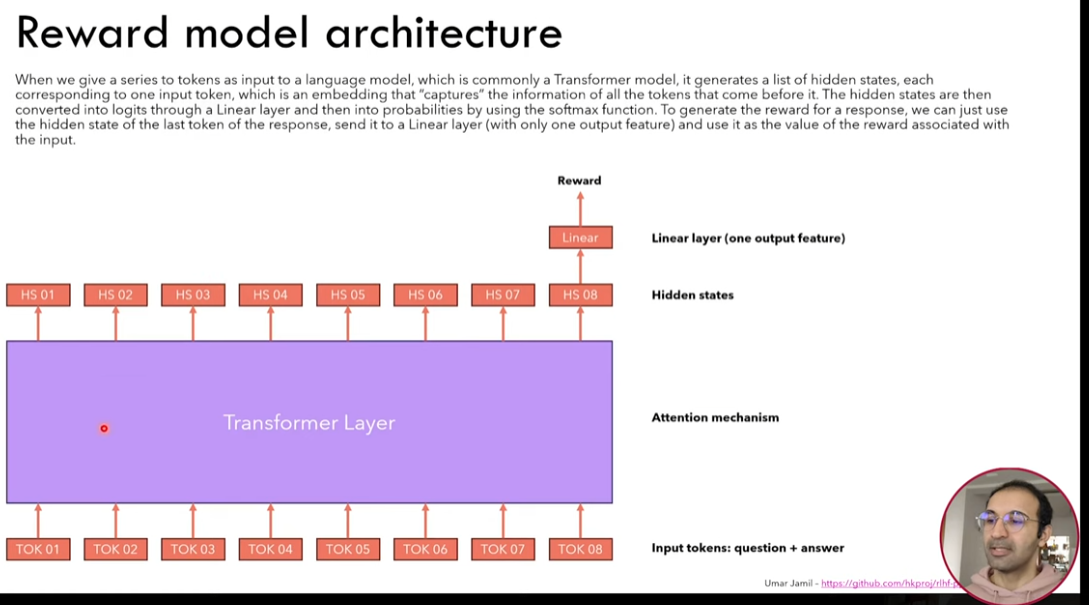

What we do is take a pretrained model:
Feed the question + answer into the transformer

Pop-out the hidden states

Take the last linear state, project it to the vocabulary size, and get the logits

## What is the Reward model Loss Function?

```
L = -log(sigmoid(r(x, yw) - r(x, yl)))
```

Where:
- r(x, y) is the reward model
- yw is the better response
- yl is the worse response
- x is the prompt

Think about it...
If the reward difference is positive, it means that the reward for the good response is higher than the reward for the bad response. So the loss will be low.

```
Example:
reward value range = [0, 1]
r(x, yw) = 0.8
r(x, yl) = 0.2

L = -log(sigmoid(0.8 - 0.2)) = -log(sigmoid(0.6)) = -log(0.645) = 0.438
```

If the reward difference is negative, it means that the reward for the bad response is higher than the reward for the good response. So the loss will be high.

```
Example:
reward value range = [0, 1]
r(x, yw) = 0.2
r(x, yl) = 0.8

L = -log(sigmoid(0.2 - 0.8)) = -log(sigmoid(-0.6)) = -log(0.355) = 1.04
```

## Let's talk about trajectories in Reinforcement Learning

A trajectory is a sequence of states, actions, and rewards. It is the path that the agent takes through the environment. The goal of reinforcement learning is to find the optimal policy that maximizes the expected reward. This is done by learning from the trajectories generated by the agent.

In other words, the trajectory is the optimal path for a mouse to get the cheese.
$$
\pi^* = \arg\max_{\pi} (J(\pi))
$$

Where:
- \( \pi \) is the policy
- \( J(\pi) \) is the expected reward
  - \( J(\pi) = \int P(t|\pi) \cdot R(t) \, dt = E[R(t)] \)
  - \( t = (s_0, a_0, r_0, s_1, a_1, r_1, \ldots, s_n, a_n, r_n) \)
  - \( s(t+1) \sim P(*|s_t, a_t) \)
  - \( P(t|\pi) = p_0 \cdot s_0 + p_1 \cdot s_1 + \ldots + p_n \cdot s_n \)
  - \( R(t) = g_0 \cdot r_0 + g_1 \cdot r_1 + \ldots + g_n \cdot r_n \)
- \( \pi^* \) is the optimal policy

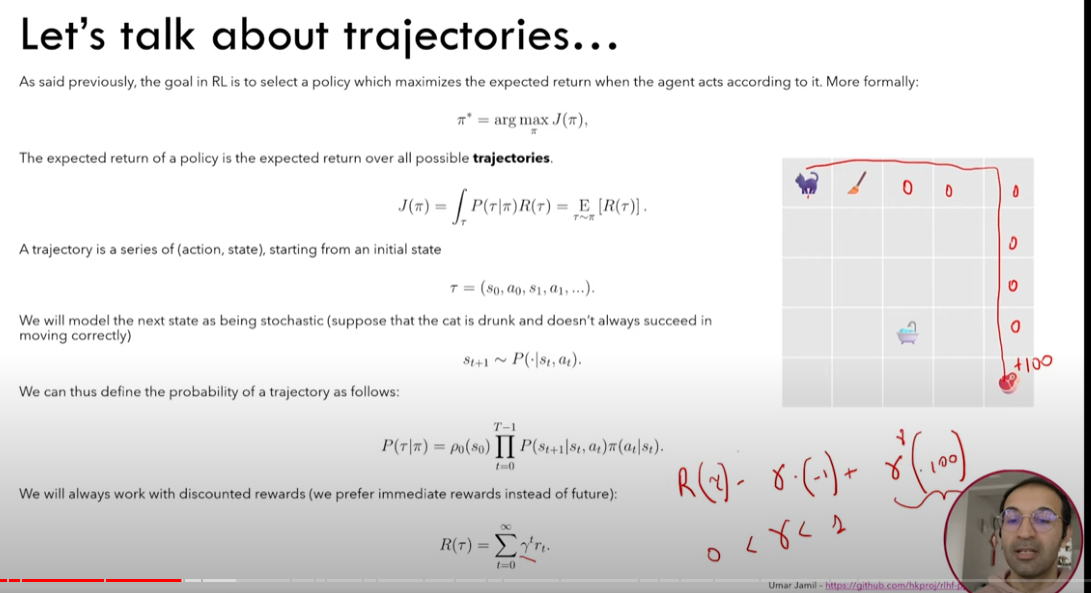

## Trajectories in Language Models
Similar to the basic RL Mouse and Cheese example, we can think of the trajectory in LLMs as the optimal path for the model to generate the best response to a given prompt. The goal is to learn a policy that maximizes the expected reward while minimizing the feedback.

We have a state (prompt), an action (next token prediction). The next token is appended to the input creating a new state. The process is repeated until the end of the response.

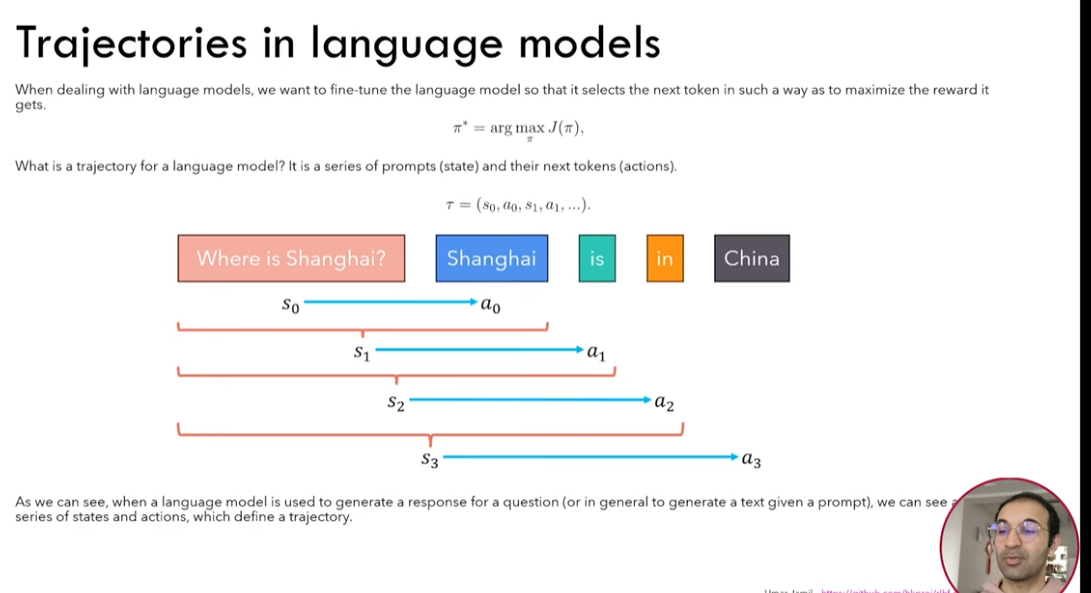


## Policy Gradient Optimization (PPO)

PPO is a reinforcement learning algorithm that is used to optimize the policy of an agent. It is based on the idea of policy gradients, which are used to update the policy in the direction that increases the expected reward. The goal of PPO is to find the policy that maximizes the expected reward while minimizing the feedback.

PPO is an objective function, so instead of gradient descent we use gradient ascent. The objective function is the expected reward, which is the sum of the rewards over the trajectory. The goal is to maximize the expected reward by updating the policy in the direction that increases the reward.

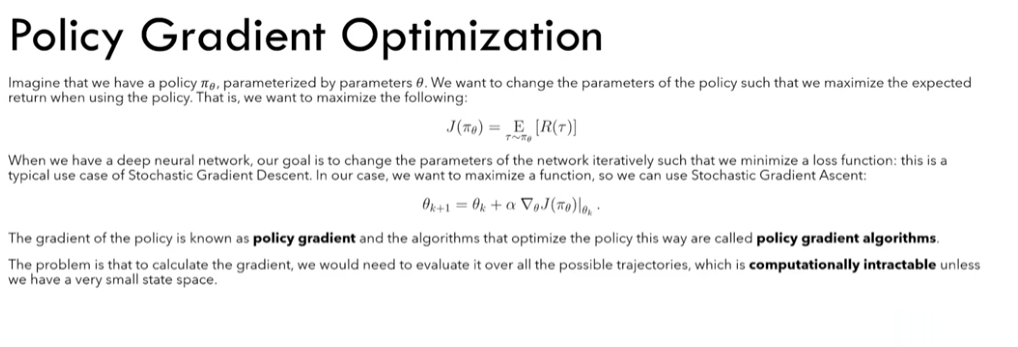

Derevation:

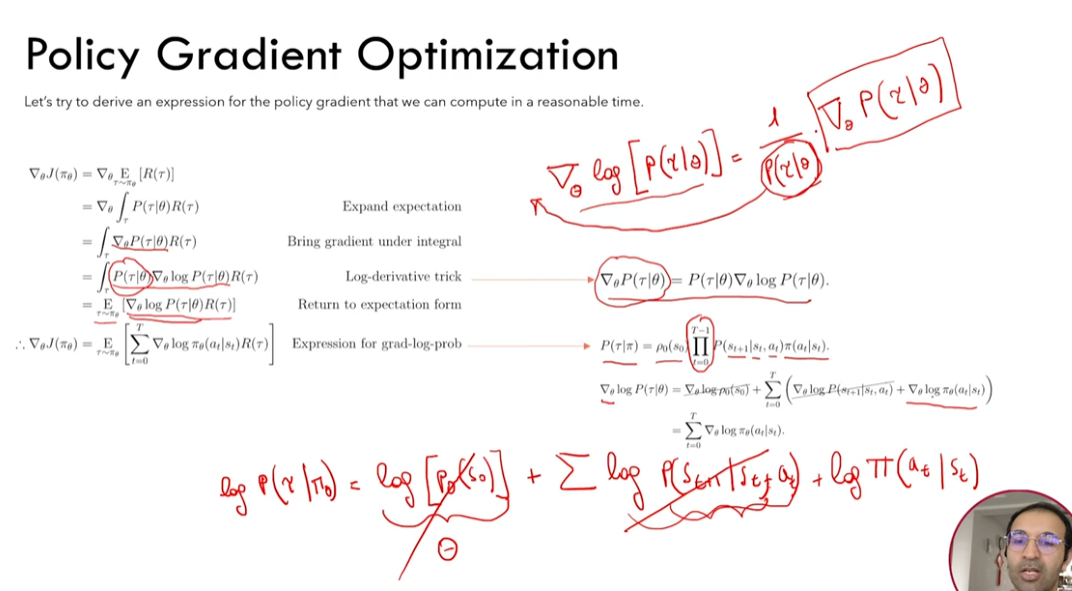

However this is intractable, so we can replace the expectation with a sample average.

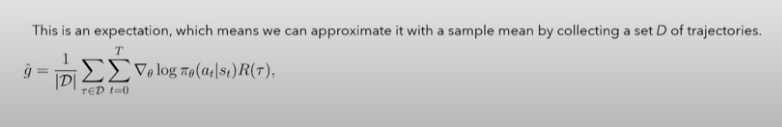

Recap:

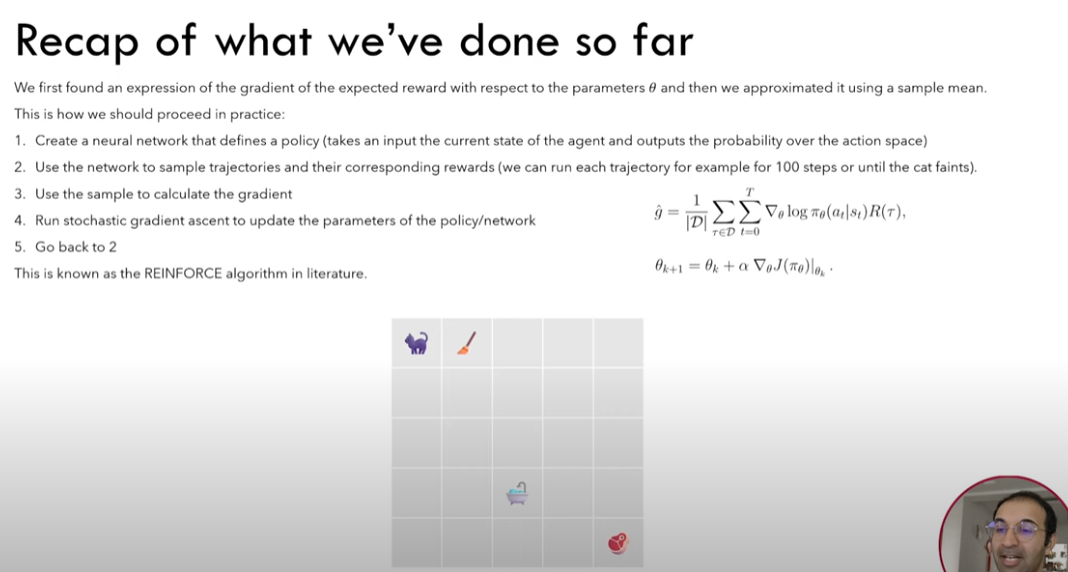

## Calculating log-probabilities from the autoregressive transformer

If the input is:
```
Where is Shanghai? Shanghai
```

We only care about the log-probability of the last token (Shanghai).

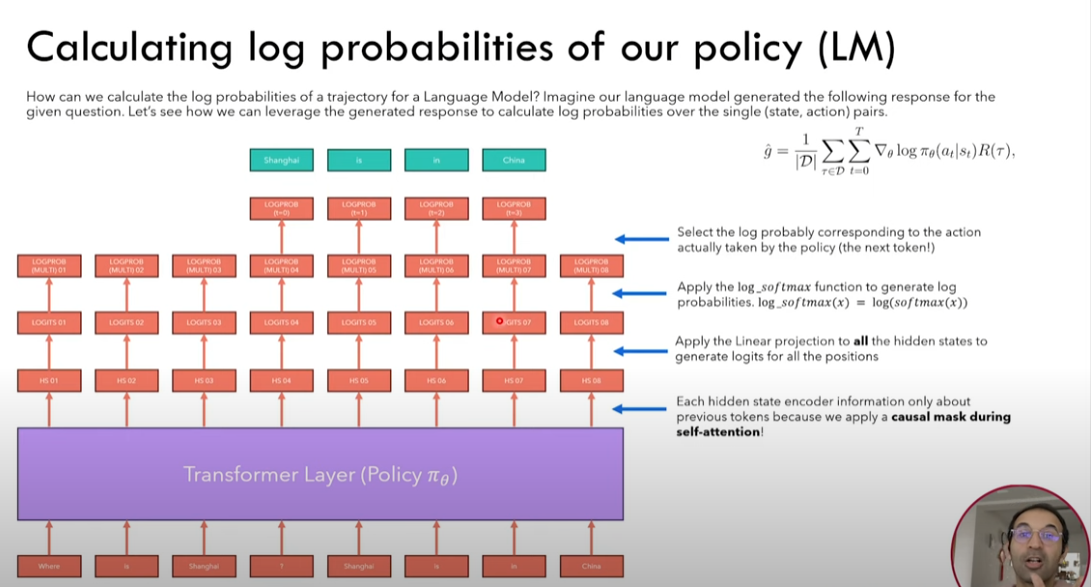

## Problems with Gradient Policy Optimization

1. High Variance. There is high variance based on gradient approximation, which leads to instability or even divergence.
- Solution: Use a baseline to reduce variance. The baseline is the expected reward of the state.
  

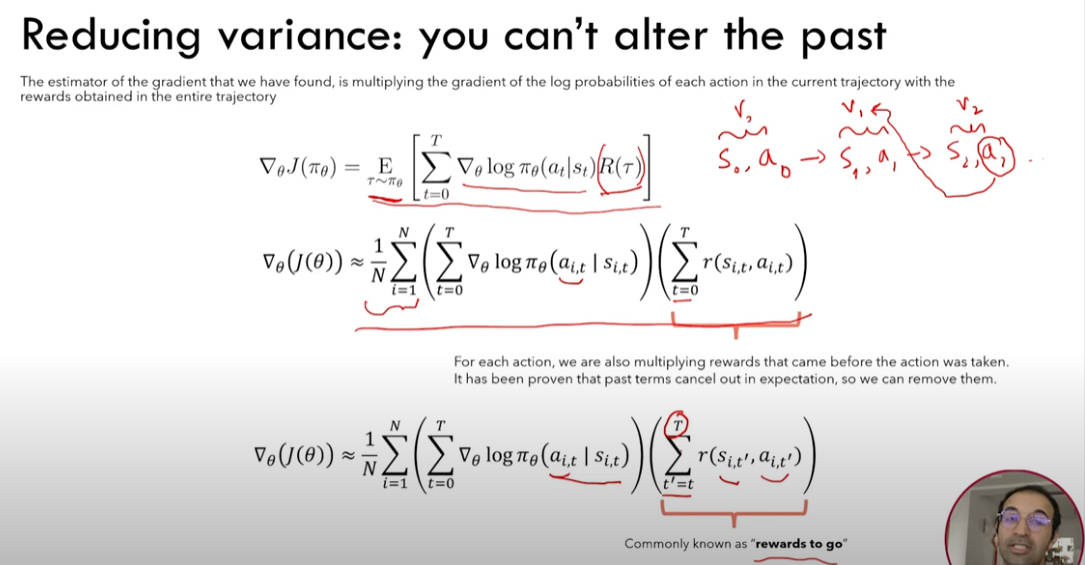

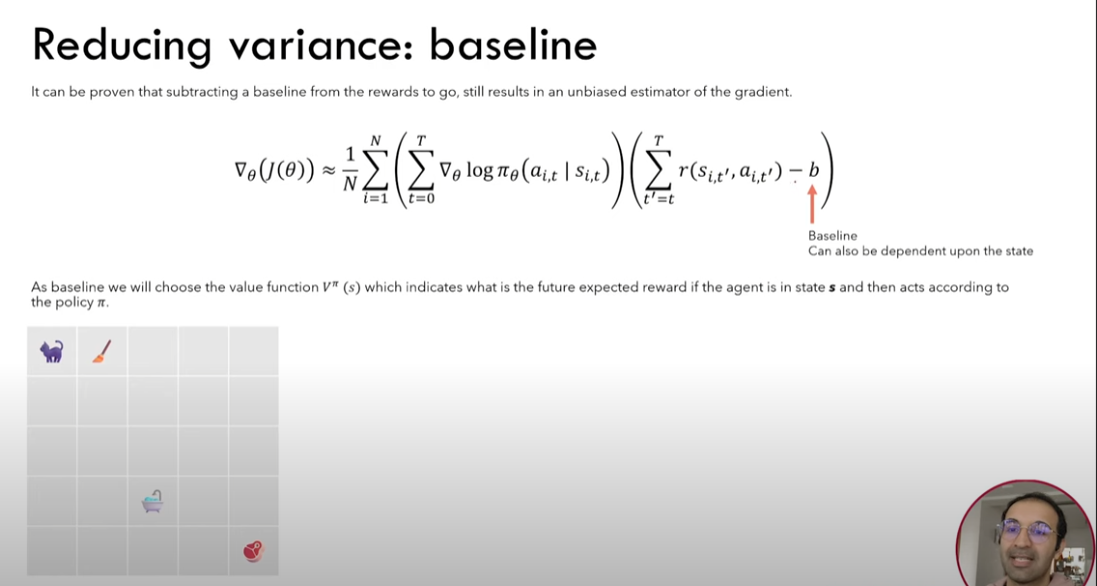

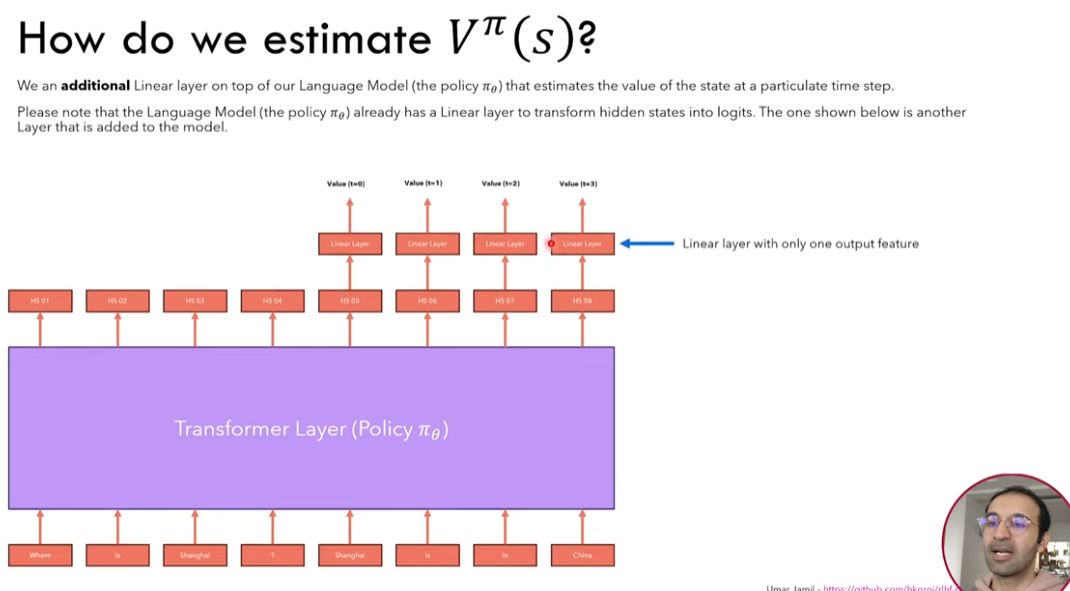

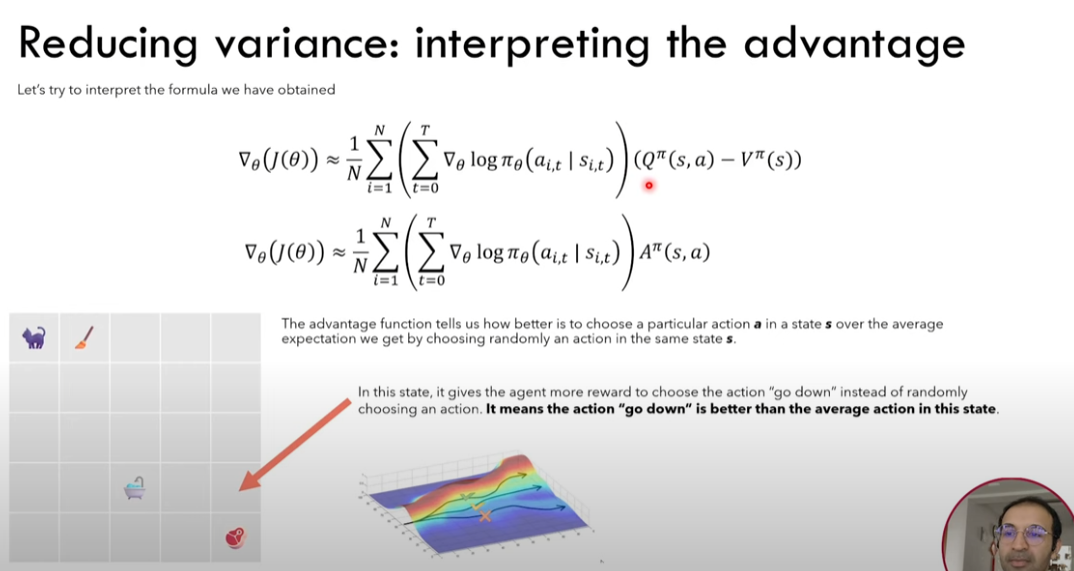



In [ ]:
import gc
import random
import warnings
from contextlib import contextmanager
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from transformers import top_k_top_p_filtering

from .import_utils import is_npu_available, is_xpu_available


try:
    from collections.abc import Mapping
except ImportError:
    from collections.abc import Mapping

import inspect
import math
import os
import time
import typing
import warnings
from contextlib import nullcontext
from typing import Callable, List, Optional, Union

import datasets
import numpy as np
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration, gather_object, is_deepspeed_available
from datasets import Dataset
from huggingface_hub import whoami
from packaging import version
from torch.optim import Adam
from transformers import (
    DataCollatorForLanguageModeling,
    PreTrainedTokenizer,
    PreTrainedTokenizerBase,
    PreTrainedTokenizerFast,
)

from ..core import (
    WANDB_PADDING,
    PPODecorators,
    clip_by_value,
    convert_to_scalar,
    entropy_from_logits,
    flatten_dict,
    logprobs_from_logits,
    masked_mean,
    masked_var,
    masked_whiten,
    set_seed,
    stack_dicts,
    stats_to_np,
)
from ..import_utils import is_npu_available, is_torch_greater_2_0, is_xpu_available
from ..models import SUPPORTED_ARCHITECTURES, PreTrainedModelWrapper, create_reference_model
from . import AdaptiveKLController, BaseTrainer, FixedKLController, PPOConfig, RunningMoments


if is_deepspeed_available():
    import deepspeed

import torch
from tqdm import tqdm

from transformers import pipeline, AutoTokenizer
from datasets import load_dataset

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

In [ ]:
# Copyright 2022 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


WANDB_PADDING = -1


def flatten_dict(nested: Dict, sep: str = "/") -> Dict:
    """Flatten dictionary and concatenate nested keys with separator."""

    def recurse(nest: Dict, prefix: str, into: Dict) -> None:
        for k, v in nest.items():
            if sep in k:
                raise ValueError(f"separator '{sep}' not allowed to be in key '{k}'")
            if isinstance(v, Mapping):
                recurse(v, prefix + k + sep, into)
            else:
                into[prefix + k] = v

    flat = {}
    recurse(nested, "", flat)
    return flat


def convert_to_scalar(stats: Dict) -> Dict:
    """
    Converts the stats from a flattened dict to single scalar dicts
    """
    tensorboard_stats = {}
    for k, v in stats.items():
        # for tensorboard compatibility - arrays and tensors are ignored with tensorboard
        # therefore we convert single element tensors to scalars
        if (isinstance(v, torch.Tensor) or isinstance(v, np.ndarray)) and (
            len(v.shape) == 0 or (len(v.shape) == 1 and v.shape[0] == 1)
        ):
            v = v.item()
        tensorboard_stats[k] = v
    return tensorboard_stats


def stack_dicts(stats_dicts: List[Dict]) -> Dict:
    """Stack the values of a dict."""
    results = dict()
    for k in stats_dicts[0]:
        stats_list = [torch.flatten(d[k]) for d in stats_dicts]
        results[k] = pad_sequence(stats_list, batch_first=True, padding_value=WANDB_PADDING)
    return results


def add_suffix(input_dict: Dict, suffix: str) -> Dict:
    """Add suffix to dict keys."""
    return {k + suffix: v for k, v in input_dict.items()}


def pad_to_size(tensor: torch.Tensor, size: int, dim: int = 1, padding: int = 50256) -> torch.Tensor:
    """Pad tensor to size."""
    t_size = tensor.size()[dim]
    if t_size == size:
        return tensor
    else:
        return torch.nn.functional.pad(tensor, (0, size - t_size), "constant", padding)


def logprobs_from_logits(logits: torch.Tensor, labels: torch.Tensor, gather: bool = True) -> torch.Tensor:
    """
    See: https://github.com/pytorch/pytorch/issues/563#issuecomment-330103591
    """
    logp = F.log_softmax(logits, dim=2)

    if not gather:
        return logp
    logpy = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logpy


def whiten(values: torch.Tensor, shift_mean: bool = True) -> torch.Tensor:
    """Whiten values."""
    mean, var = torch.mean(values), torch.var(values)
    whitened = (values - mean) * torch.rsqrt(var + 1e-8)
    if not shift_mean:
        whitened += mean
    return whitened


def masked_mean(values: torch.Tensor, mask: torch.Tensor, axis: Optional[bool] = None) -> torch.Tensor:
    """Compute mean of tensor with a masked values."""
    if axis is not None:
        return (values * mask).sum(axis=axis) / mask.sum(axis=axis)
    else:
        return (values * mask).sum() / mask.sum()


def masked_var(values: torch.Tensor, mask: torch.Tensor, unbiased: bool = True) -> torch.Tensor:
    """Compute variance of tensor with masked values."""
    mean = masked_mean(values, mask)
    centered_values = values - mean
    variance = masked_mean(centered_values**2, mask)
    if unbiased:
        mask_sum = mask.sum()
        if mask_sum == 0:
            raise ValueError(
                "The sum of the mask is zero, which can happen when `mini_batch_size=1`;"
                "try increase the `mini_batch_size` or `gradient_accumulation_steps`"
            )
        # note that if mask_sum == 1, then there is a division by zero issue
        # to avoid it you just need to use a larger minibatch_size
        bessel_correction = mask_sum / (mask_sum - 1)
        variance = variance * bessel_correction
    return variance


def masked_whiten(values: torch.Tensor, mask: torch.Tensor, shift_mean: bool = True) -> torch.Tensor:
    """Whiten values with masked values."""
    mean, var = masked_mean(values, mask), masked_var(values, mask)
    whitened = (values - mean) * torch.rsqrt(var + 1e-8)
    if not shift_mean:
        whitened += mean
    return whitened


def clip_by_value(x: torch.Tensor, tensor_min: float, tensor_max: float) -> torch.Tensor:
    """
    Tensor extension to torch.clamp
    https://github.com/pytorch/pytorch/issues/2793#issuecomment-428784713
    """
    clipped = torch.max(torch.min(x, tensor_max), tensor_min)
    return clipped


def entropy_from_logits(logits: torch.Tensor) -> torch.Tensor:
    """Calculate entropy from logits."""
    # More info here:
    # 1) Wikipedia: "The convex conjugate of LogSumExp is the negative entropy." - https://en.wikipedia.org/wiki/LogSumExp
    # 2) https://math.stackexchange.com/questions/2614316/conjugate-function-of-log-sum-exp
    # 3) The Log-Sum-Exp Trick - https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    pd = torch.nn.functional.softmax(logits, dim=-1)
    entropy = torch.logsumexp(logits, axis=-1) - torch.sum(pd * logits, axis=-1)
    return entropy


def average_torch_dicts(list_of_dicts: List[Dict]) -> Dict:
    """Average values of a list of dicts with torch tensors."""
    average_dict = dict()
    for key in list_of_dicts[0].keys():
        average_dict[key] = torch.mean(torch.stack([d[key] for d in list_of_dicts]), axis=0)
    return average_dict


def stats_to_np(stats_dict: Dict) -> Dict:
    """Cast all torch.tensors in dict to numpy arrays."""
    new_dict = dict()
    for k, v in stats_dict.items():
        if isinstance(v, torch.Tensor):
            new_dict[k] = v.detach().cpu()
            if new_dict[k].dtype == torch.bfloat16:
                new_dict[k] = new_dict[k].float()
            new_dict[k] = new_dict[k].numpy()
        else:
            new_dict[k] = v
        if np.isscalar(new_dict[k]):
            new_dict[k] = float(new_dict[k])
    return new_dict


def respond_to_batch(
    model: nn.Module, queries: List[torch.LongTensor], txt_len: int = 20, top_k: int = 0, top_p: float = 1.0
) -> torch.LongTensor:
    """Sample text from language model."""
    input_ids = queries
    for _i in range(txt_len):
        # Get Logits
        outputs = model(input_ids)
        next_token_logits = outputs[0][:, -1, :]
        next_token_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
        # Sample
        probs = F.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).squeeze(1)
        input_ids = torch.cat([input_ids, next_token.unsqueeze(-1)], dim=-1)
    return input_ids[:, -txt_len:]


def set_seed(seed: int) -> None:
    """
    Helper function for reproducible behavior to set the seed in `random`, `numpy`, and `torch`.

    Args:
        seed (`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if is_xpu_available():
        torch.xpu.manual_seed_all(seed)
    elif is_npu_available():
        torch.npu.manual_seed_all(seed)
    else:
        torch.cuda.manual_seed_all(seed)


class LengthSampler:
    """
    Samples a length
    """

    def __init__(self, min_value: int, max_value: int):
        self.values = list(range(min_value, max_value))

    def __call__(self) -> int:
        return np.random.choice(self.values)


class PPODecorators:
    optimize_device_cache = False

    @classmethod
    @contextmanager
    def empty_device_cache(cls):
        yield
        if cls.optimize_device_cache:
            if is_xpu_available():
                gc.collect()
                torch.xpu.empty_cache()
                gc.collect()
            elif is_npu_available():
                gc.collect()
                torch.npu.empty_cache()
                gc.collect()
            elif torch.cuda.is_available():
                gc.collect()
                torch.cuda.empty_cache()
                gc.collect()


def randn_tensor(
    shape: Union[Tuple, List],
    generator: Optional[Union[List[torch.Generator], torch.Generator]] = None,
    device: Optional[torch.device] = None,
    dtype: Optional[torch.dtype] = None,
    layout: Optional[torch.layout] = None,
) -> torch.Tensor:
    """A helper function to create random tensors on the desired `device` with the desired `dtype`. When
    passing a list of generators, you can seed each batch size individually. If CPU generators are passed, the tensor
    is always created on the CPU.
    """
    # device on which tensor is created defaults to device
    rand_device = device
    batch_size = shape[0]

    layout = layout or torch.strided
    device = device or torch.device("cpu")

    if generator is not None:
        gen_device_type = generator.device.type if not isinstance(generator, list) else generator[0].device.type
        if gen_device_type != device.type and gen_device_type == "cpu":
            rand_device = "cpu"
            if device != "mps":
                warnings.warn(
                    f"The passed generator was created on 'cpu' even though a tensor on {device} was expected."
                    f" Tensors will be created on 'cpu' and then moved to {device}. Note that one can probably"
                    f" slighly speed up this function by passing a generator that was created on the {device} device."
                )
        elif gen_device_type != device.type and gen_device_type == "cuda":
            raise ValueError(f"Cannot generate a {device} tensor from a generator of type {gen_device_type}.")

    # make sure generator list of length 1 is treated like a non-list
    if isinstance(generator, list) and len(generator) == 1:
        generator = generator[0]

    if isinstance(generator, list):
        shape = (1,) + shape[1:]
        latents = [
            torch.randn(shape, generator=generator[i], device=rand_device, dtype=dtype, layout=layout)
            for i in range(batch_size)
        ]
        latents = torch.cat(latents, dim=0).to(device)
    else:
        latents = torch.randn(shape, generator=generator, device=rand_device, dtype=dtype, layout=layout).to(device)

    return latents

In [ ]:
# Copyright 2022 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


MODEL_CARD_TEMPLATE = """---
license: apache-2.0
tags:
- trl
- ppo
- transformers
- reinforcement-learning
---

# {model_name}

This is a [TRL language model](https://github.com/huggingface/trl) that has been fine-tuned with reinforcement learning to
 guide the model outputs according to a value, function, or human feedback. The model can be used for text generation.

## Usage

To use this model for inference, first install the TRL library:

```bash
python -m pip install trl
```

You can then generate text as follows:

```python
from transformers import pipeline

generator = pipeline("text-generation", model="{model_id}")
outputs = generator("Hello, my llama is cute")
```

If you want to use the model for training or to obtain the outputs from the value head, load the model as follows:

```python
from transformers import AutoTokenizer
from trl import AutoModelForCausalLMWithValueHead

tokenizer = AutoTokenizer.from_pretrained("{model_id}")
model = AutoModelForCausalLMWithValueHead.from_pretrained("{model_id}")

inputs = tokenizer("Hello, my llama is cute", return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"])
```
"""


class PPOTrainer(BaseTrainer):
    """
    The PPOTrainer uses Proximal Policy Optimization to optimise language models.
    Note, this trainer is heavily inspired by the original OpenAI learning to summarize work here:
    https://github.com/openai/summarize-from-feedback

    Attributes:
        **config** (`PPOConfig`) -- Configuration object for PPOTrainer. Check the documentation of `PPOConfig` for more
            details.
        **model** (`PreTrainedModelWrapper`) -- Model to be optimized, Hugging Face transformer model with a value head.
            Check the documentation of `PreTrainedModelWrapper` for more details.
        **ref_model** (`PreTrainedModelWrapper`, *optional*) -- Reference model to be used for KL penalty, Hugging Face
            transformer model with a casual language modelling head. Check the documentation of `PreTrainedModelWrapper`
            for more details. If no reference model is provided, the trainer will create a reference model with the same
             architecture as the model to be optimized with shared layers.
        **tokenizer** (`PreTrainedTokenizerBase`) -- Tokenizer to be used for encoding the
            data. Check the documentation of `transformers.PreTrainedTokenizer` and
            `transformers.PreTrainedTokenizerFast` for more details.
        **dataset** (Union[`torch.utils.data.Dataset`, `datasets.Dataset`], *optional*) -- PyTorch dataset or Hugging
            Face dataset. This is used to create a PyTorch dataloader. If no dataset is provided, the dataloader must be
             created outside the trainer users needs to design their own dataloader and make sure the batch
            size that is used is the same as the one specified in the configuration object.
        **optimizer** (`torch.optim.Optimizer`, *optional*) -- Optimizer to be used for training. If no optimizer is
            provided, the trainer will create an Adam optimizer with the learning rate specified in the configuration
            object.
        **data_collator** (DataCollatorForLanguageModeling, *optional*) -- Data collator to be used for training and
            passed along the dataloader
        **num_shared_layers** (int, *optional*) -- Number of layers to be shared between the model and the reference
            model, if no reference model is passed. If no number is provided, all the layers will be shared.
        **lr_scheduler** (`torch.optim.lr_scheduler`, *optional*) -- Learning rate scheduler to be used for training.
    """

    _tag_names = ["trl", "ppo"]

    def __init__(
        self,
        config: Optional[PPOConfig] = None,
        model: Optional[PreTrainedModelWrapper] = None,
        ref_model: Optional[PreTrainedModelWrapper] = None,
        tokenizer: Optional[PreTrainedTokenizerBase] = None,
        dataset: Optional[Union[torch.utils.data.Dataset, Dataset]] = None,
        optimizer: Optional[torch.optim.Optimizer] = None,
        data_collator: Optional[typing.Callable] = None,
        num_shared_layers: Optional[int] = None,
        lr_scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    ):
        """
        Initialize PPOTrainer.

        Args:
            config (`PPOConfig`):
                Configuration object for PPOTrainer. Check the documentation of `PPOConfig` for more details.
            model (`PreTrainedModelWrapper`):
                Hugging Face transformer model with a value head.
            ref_model (`PreTrainedModelWrapper`):
                Hugging Face transformer model with a casual language modelling head. Used for KL penalty
            tokenizer (`transformers.PreTrainedTokenizerBase`):
                Hugging Face tokenizer
            dataset (Optional[Union[`torch.utils.data.Dataset`, `datasets.Dataset`]]):
                PyTorch dataset or Hugging Face dataset. If a Hugging Face dataset is passed, the dataset
                will be preprocessed by removing the columns that are not used by the model. If none is passed,
                a warning will be raised in a multi-GPU setting.
            optimizer (Optional[`torch.optim.Optimizer`]):
                Optimizer used for training. If `None`, the `Adam` is used as default.
            data_collator (Optional[function]):
                Data collator function.
            num_shared_layers (Optional[int]):
                Number of shared layers between the model and the reference model. If `None`, all layers are shared.
                used only if `ref_model` is `None`.
            lr_scheduler (Optional[`torch.optim.lr_scheduler`]):
                Learning rate scheduler used for training.
        """
        super().__init__(config)

        # initial seed for reproducible experiments
        set_seed(config.seed)

        # Step 0: check positional arguments validity
        if not isinstance(config, PPOConfig):
            raise ValueError(f"config must be a PPOConfig, got {type(config)}")
        if not isinstance(tokenizer, (PreTrainedTokenizerBase)):
            raise ValueError(
                f"tokenizer must be a PreTrainedTokenizerBase like a PreTrainedTokenizer or a PreTrainedTokenizerFast, got {type(tokenizer)}"
            )
        if not isinstance(model, (SUPPORTED_ARCHITECTURES)):
            raise ValueError(
                f"model must be a PreTrainedModelWrapper, got {type(model)} - supported architectures are: {SUPPORTED_ARCHITECTURES}"
            )
        # Step 1: Initialize Accelerator
        self.accelerator = Accelerator(
            log_with=config.log_with,
            gradient_accumulation_steps=config.gradient_accumulation_steps,
            project_config=ProjectConfiguration(**config.project_kwargs),
            **config.accelerator_kwargs,
        )

        # Step 1.1 Runtime variables filled by the accelerator
        config.world_size = self.accelerator.num_processes
        config.global_backward_batch_size = config.backward_batch_size * config.world_size
        config.global_batch_size = config.batch_size * config.world_size

        self.model = model
        self.model_params = filter(lambda p: p.requires_grad, self.model.parameters())
        self.is_encoder_decoder = hasattr(self.model, "is_encoder_decoder")
        self.is_peft_model = getattr(self.model, "is_peft_model", False)
        config.is_encoder_decoder = self.is_encoder_decoder
        config.is_peft_model = self.is_peft_model

        is_using_tensorboard = config.log_with is not None and config.log_with == "tensorboard"
        self.accelerator.init_trackers(
            config.tracker_project_name,
            config=dict(trl_ppo_trainer_config=config.to_dict()) if not is_using_tensorboard else config.to_dict(),
            init_kwargs=config.tracker_kwargs,
        )
        self.is_using_text_environment = getattr(config, "use_text_environment", False)

        if isinstance(ref_model, SUPPORTED_ARCHITECTURES):
            self.ref_model = ref_model
            if num_shared_layers is not None:
                warnings.warn(
                    "num_shared_layers is ignored when ref_model is provided. Two different models are used for the "
                    "model and the reference model and no layers are shared.",
                    UserWarning,
                )
        elif ref_model is None and not self.is_peft_model:
            self.ref_model = create_reference_model(self.model, num_shared_layers=num_shared_layers)
        elif self.is_peft_model:
            self.ref_model = None
        else:
            raise ValueError(
                f"ref_model must be a PreTrainedModelWrapper or `None`, got {type(ref_model)} - supported "
                f"architectures are: {SUPPORTED_ARCHITECTURES} "
            )
        self.optional_peft_ctx = (
            self.accelerator.unwrap_model(self.model).pretrained_model.disable_adapter
            if self.is_peft_model
            else nullcontext
        )

        if not (isinstance(tokenizer, PreTrainedTokenizer) or isinstance(tokenizer, PreTrainedTokenizerFast)):
            raise ValueError(
                "tokenizer must be a transformers.PreTrainedTokenizer or transformers.PreTrainedTokenizerFast"
            )
        self.tokenizer = tokenizer

        if dataset is not None and not (isinstance(dataset, torch.utils.data.Dataset) or isinstance(dataset, Dataset)):
            raise ValueError("dataset must be a torch.utils.data.Dataset or datasets.Dataset")
        elif dataset is None:
            warnings.warn(
                "No dataset is provided. Make sure to set config.batch_size to the correct value before training.",
                UserWarning,
            )
        self.dataset = dataset
        self._signature_columns = None
        if self.dataset is not None:
            self.dataloader = self.prepare_dataloader(self.dataset, data_collator)
        elif self.dataset is None and self.accelerator.num_processes > 1:
            warnings.warn(
                "No dataset is provided. In a multi-GPU setting, this will lead to an error. You should"
                " prepare your dataloader yourself with `dataloader = ppo_trainer.accelerator.prepare(dataloader)`"
                " and using `torch.utils.data.DataLoader`, or pass a dataset to the `PPOTrainer`. Please "
                " refer to the documentation for more details.",
                UserWarning,
            )
            self.dataloader = None
        else:
            self.dataloader = None

        # Step 3: Initialize optimizer and data collator
        self.data_collator = DataCollatorForLanguageModeling(self.tokenizer, mlm=False)
        if optimizer is None:
            self.optimizer = Adam(
                filter(lambda p: p.requires_grad, self.model.parameters()),
                lr=self.config.learning_rate,
            )
        else:
            self.optimizer = optimizer

        self.lr_scheduler = lr_scheduler
        if self.lr_scheduler is not None:
            lr_scheduler_class = (
                torch.optim.lr_scheduler._LRScheduler
                if not is_torch_greater_2_0()
                else torch.optim.lr_scheduler.LRScheduler
            )

            if not isinstance(self.lr_scheduler, lr_scheduler_class):
                raise ValueError(
                    "lr_scheduler must be a torch.optim.lr_scheduler._LRScheduler or torch.optim.lr_scheduler.LRScheduler (for torch >= 2.0)"
                )

        if self.config.adap_kl_ctrl:
            self.kl_ctl = AdaptiveKLController(self.config.init_kl_coef, self.config.target, self.config.horizon)
        else:
            self.kl_ctl = FixedKLController(self.config.init_kl_coef)

        # Safety checkers for DS integration
        is_deepspeed_used = self.accelerator.distributed_type == "DEEPSPEED" and hasattr(
            self.accelerator.state, "deepspeed_plugin"
        )

        (
            self.model,
            self.optimizer,
            self.data_collator,
            self.dataloader,
            self.lr_scheduler,
        ) = self.accelerator.prepare(
            self.model,
            self.optimizer,
            self.data_collator,
            self.dataloader,
            self.lr_scheduler,
        )
        if is_deepspeed_used:
            # Quantized models are already set on the correct device
            if not self.is_peft_model and not (
                getattr(self.ref_model.pretrained_model, "is_loaded_in_8bit", False)
                or getattr(self.ref_model.pretrained_model, "is_loaded_in_4bit", False)
            ):
                self.ref_model = self._prepare_deepspeed(self.ref_model)
        else:
            self.ref_model = self.accelerator.prepare(self.ref_model)

        # In a distributed setup, only logging needs to be performed on the main process
        # check: https://pytorch.org/docs/stable/generated/torch.nn.parallel.DistributedDataParallel.html
        # or: https://discuss.pytorch.org/t/use-distributed-data-parallel-correctly/82500/11
        self.is_distributed = self.accelerator.num_processes > 1

        # init the current step
        self.current_step = 0

        # init variables for pushing model to hub
        if config.push_to_hub_if_best_kwargs:
            if "repo_id" not in config.push_to_hub_if_best_kwargs:
                raise ValueError("You have to specify repo_id in order to push the model to the hub!")
            self.push_to_hub_kwargs = config.push_to_hub_if_best_kwargs
            self.compare_step = 0
            self.highest_reward = torch.tensor(-float("inf"))

        # post process for PP
        if not getattr(self.model, "is_sequential_parallel", False):
            self.current_device = self.accelerator.device
        else:
            if is_xpu_available():
                self.current_device = torch.device("xpu:0")
            elif is_npu_available():
                self.current_device = torch.device("npu:0")
            else:
                self.current_device = torch.device("cuda:0")

        PPODecorators.optimize_device_cache = self.config.optimize_device_cache

        self.running = RunningMoments(self.accelerator)

    def _filter_kwargs(self, kwargs, target_func):
        """
        filter the keyword arguments that are supported by the target function.

        Args:
            kwargs (dict):
                Keyword arguments
            target_func (function):
                Target function
        """
        return {k: v for k, v in kwargs.items() if k in inspect.signature(target_func).parameters.keys()}

    def prepare_dataloader(self, dataset: Union[torch.utils.data.Dataset, Dataset], data_collator=None):
        """
        Prepare the dataloader for training.

        Args:
            dataset (Union[`torch.utils.data.Dataset`, `datasets.Dataset`]):
                PyTorch dataset or Hugging Face dataset. If a Hugging Face dataset is passed, the dataset
                will be preprocessed by removing the columns that are not used by the model.
            data_collator (Optional[function]):
                Data collator function.

        Returns:
            `torch.utils.data.DataLoader`: PyTorch dataloader
        """
        if isinstance(dataset, Dataset):
            dataset = self._remove_unused_columns(dataset)
        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=self.config.batch_size,
            collate_fn=data_collator,
            shuffle=True,
            drop_last=True,
        )
        return dataloader

    # Adapted from transformers.Trainer._set_signature_columns_if_needed
    def _set_signature_columns_if_needed(self):
        if self._signature_columns is None:
            # Inspect model forward signature to keep only the arguments it accepts.
            signature = inspect.signature(self.model.forward)
            self._signature_columns = list(signature.parameters.keys())
            # label => sentiment | we need query and response for logging purpose
            self._signature_columns += ["label", "query", "response"]

    # Adapted from transformers.Trainer._remove_unused_columns
    def _remove_unused_columns(self, dataset: "Dataset"):
        if not self.config.remove_unused_columns:
            return dataset
        self._set_signature_columns_if_needed()
        signature_columns = self._signature_columns

        ignored_columns = list(set(dataset.column_names) - set(signature_columns))

        columns = [k for k in signature_columns if k in dataset.column_names]

        if version.parse(datasets.__version__) < version.parse("1.4.0"):
            dataset.set_format(
                type=dataset.format["type"],
                columns=columns,
                format_kwargs=dataset.format["format_kwargs"],
            )
            return dataset
        else:
            return dataset.remove_columns(ignored_columns)

    def generate(
        self,
        query_tensor: Union[torch.Tensor, List[torch.Tensor]],
        length_sampler: Optional[Callable] = None,
        batch_size: int = 4,
        return_prompt: bool = True,
        generate_ref_response: bool = False,
        **generation_kwargs,
    ):
        """
        Generate response with the model given the query tensor.
        call the `generate` method of the model.

        Args:
            query_tensor (`torch.LongTensor`):
                A tensor of shape (`seq_len`) containing query tokens or a list of tensors of shape (`seq_len`).
            length_sampler (`Callable`, *optional*):
                Callable that returns the number of newly generated tokens.
            batch_size (`int`, *optional):
                Batch size used for generation, defaults to `4`.
            return_prompt (`bool`, *optional*):
                If set to `False` the prompt is not returned but only the newly generated tokens, defaults to `True`.
            generate_ref_response (`bool`, *optional*):
                If set to `True` the reference response is also generated, defaults to `False`.
            generation_kwargs (dict[str, Any]):
                Keyword arguments for generation.

        Returns:
            `torch.LongTensor`: A tensor of shape (`batch_size`, `gen_len`) containing response tokens.
        """
        if generate_ref_response:
            ref_model = self.model if self.is_peft_model else self.ref_model
        if isinstance(query_tensor, List):
            response = self._generate_batched(
                self.model,
                query_tensor,
                length_sampler=length_sampler,
                batch_size=batch_size,
                return_prompt=return_prompt,
                **generation_kwargs,
            )
            if generate_ref_response:
                with self.optional_peft_ctx():
                    ref_response = self._generate_batched(
                        ref_model,
                        query_tensor,
                        length_sampler=length_sampler,
                        batch_size=batch_size,
                        return_prompt=return_prompt,
                        **generation_kwargs,
                    )

        else:
            if len(query_tensor.shape) == 2:
                raise ValueError(
                    "query_tensor must be a tensor of shape (`seq_len`) or a list of tensors of shape (`seq_len`)"
                )

            if length_sampler is not None:
                generation_kwargs["max_new_tokens"] = length_sampler()
            response = self.accelerator.unwrap_model(self.model).generate(
                input_ids=query_tensor.unsqueeze(dim=0), **generation_kwargs
            )
            if generate_ref_response:
                with self.optional_peft_ctx():
                    ref_response = ref_model.generate(input_ids=query_tensor.unsqueeze(dim=0), **generation_kwargs)

            if not return_prompt and not self.is_encoder_decoder:
                response = response[:, query_tensor.shape[0] :]
                if generate_ref_response:
                    ref_response = ref_response[:, query_tensor.shape[0] :]

        if generate_ref_response:
            return response, ref_response
        return response

    def _generate_batched(
        self,
        model: PreTrainedModelWrapper,
        query_tensors: List[torch.Tensor],
        length_sampler: Optional[Callable] = None,
        batch_size: int = 4,
        return_prompt: bool = True,
        pad_to_multiple_of: Optional[int] = None,
        remove_padding: bool = True,
        **generation_kwargs,
    ):
        outputs = []

        padding_side_default = self.tokenizer.padding_side
        if not self.is_encoder_decoder:
            self.tokenizer.padding_side = "left"

        # in case we have fewer examples than bs
        batch_size = min(len(query_tensors), batch_size)

        for i in range(0, len(query_tensors), batch_size):
            if length_sampler is not None:
                generation_kwargs["max_new_tokens"] = length_sampler()

            # prevent overflow if query tensors are not even multiple of bs
            end_index = min(len(query_tensors), i + batch_size)

            batch = query_tensors[i:end_index]
            batch_mask = [torch.ones_like(element) for element in batch]
            inputs = {"input_ids": batch, "attention_mask": batch_mask}

            padded_inputs = self.tokenizer.pad(
                inputs,
                padding=True,
                max_length=None,
                pad_to_multiple_of=pad_to_multiple_of,
                return_tensors="pt",
            ).to(self.current_device)

            generations = self.accelerator.unwrap_model(model).generate(**padded_inputs, **generation_kwargs)

            for generation, mask in zip(generations, padded_inputs["attention_mask"]):
                if not self.is_encoder_decoder:
                    output = generation[(1 - mask).sum() :]  # remove padding
                else:
                    output = generation

                if not return_prompt and not self.is_encoder_decoder:
                    output = output[(mask).sum() :]  # remove prompt

                if remove_padding and self.tokenizer.eos_token_id in output:
                    pad_mask = output == self.tokenizer.eos_token_id
                    pad_start = torch.nonzero(pad_mask, as_tuple=False)[0, 0].item()
                    output = output[: pad_start + 1]  # keep the eos token at the end

                outputs.append(output)

        self.tokenizer.padding_side = padding_side_default
        return outputs

    def _step_safety_checker(
        self,
        batch_size: int,
        queries: List[torch.LongTensor],
        responses: List[torch.LongTensor],
        scores: List[torch.FloatTensor],
        masks: Optional[List[torch.LongTensor]] = None,
    ):
        """
        Check if the input data is valid for training.

        Args:
            batch_size (int):
                Batch size from the config file.
            queries (List[`torch.LongTensor`]):
                List of tensors containing the encoded queries of shape (`query_length`)
            responses (List[`torch.LongTensor`]):
                List of tensors containing the encoded responses of shape (`response_length`)
            scores (List[`torch.FloatTensor`]):
                List of tensors containing the scores.
            masks (List[`torch.LongTensor`], *optional*):
                list of optional tensors containing the masks of shape (`query_length` + `response_length`)
        Returns:
            `tuple`: The input processed data.
        """
        for name, tensor_list in zip(["queries", "responses", "scores"], [queries, responses, scores]):
            if not isinstance(tensor_list, list):
                raise ValueError(f"{name} must be a list of tensors - got {type(tensor_list)}")
            if not isinstance(tensor_list[0], torch.Tensor):
                raise ValueError(f"Elements in {name} must be tensors - got {type(tensor_list[0])}")
            if batch_size is not None and len(tensor_list) != batch_size:
                raise ValueError(
                    f"Batch size ({batch_size}) does not match number of examples - but got {len(tensor_list)} for: {name}"
                )

        # add queries, scores and responses on the correct device
        queries = [tensor.to(self.current_device) for tensor in queries]
        responses = [tensor.to(self.current_device) for tensor in responses]
        scores = [tensor.to(self.current_device) for tensor in scores]
        masks = [tensor.to(self.current_device) for tensor in masks] if masks is not None else None

        # squeeze scores if needed
        for i, score in enumerate(scores):
            if score.dim() > 1:
                raise ValueError(f"Scores must be 1-dimensional - got {score.dim()} for {score}")
            elif score.dim() == 1:
                scores[i] = score.squeeze()

        return queries, responses, scores, masks

    @PPODecorators.empty_device_cache()
    def step(
        self,
        queries: List[torch.LongTensor], # The list of prompts used to generate responses from the old model (offline policy)
        responses: List[torch.LongTensor], # A list of resnponses generated by the old model (offline policy)
        scores: List[torch.FloatTensor], # A list of reward associated with each response. One reward for each response (NOT for each token of the response)
        response_masks: Optional[List[torch.LongTensor]] = None,
    ):
        """
        Run a PPO optimisation step given a list of queries, model responses, and rewards.

        Args:
            queries (List[`torch.LongTensor`]):
                List of tensors containing the encoded queries of shape (`query_length`)
            responses (List[`torch.LongTensor`]):
                List of tensors containing the encoded responses of shape (`response_length`)
            scores (List[`torch.FloatTensor`]):
                List of tensors containing the scores.
            response_masks (List[`torch.FloatTensor`], *optional*)):
                List of tensors containing masks of the response tokens.

        Returns:
            `dict[str, Any]`: A summary of the training statistics
        """
        bs = self.config.batch_size

        # queries: input_ids of the prompts; 
        # responses: input_ids of the responses; 
        # scores: score from reward model (one per response)
        # Verify input tensors (check types, shapes, etc.)
        queries, responses, scores, response_masks = self._step_safety_checker(
            bs, queries, responses, scores, response_masks
        )
        
        # Indicates the rewards given to the responses. One scalar for each response.
        # shape: (batch_size)
        scores = torch.tensor(scores, device=self.current_device)
        
        # if self.config.use_score_scaling:
        #     # Score scaling
        #     scores_mean, scores_std = self.running.update(scores)
        #     tensor_to_kwargs = dict(dtype=scores.dtype, device=scores.device)
        #     score_scaling_factor = self.running.std.to(**tensor_to_kwargs) + torch.finfo(scores.dtype).eps
        #     if self.config.use_score_norm:
        #         scores = (scores - self.running.mean.to(**tensor_to_kwargs)) / score_scaling_factor
        #     else:
        #         scores /= score_scaling_factor

        # if self.config.score_clip is not None:
        #     # Score clipping
        #     scores_dtype = scores.dtype
        #     scores = torch.clip(scores.float(), -self.config.score_clip, self.config.score_clip).to(dtype=scores_dtype)

        # # if we want to push best model to the hub
        # if hasattr(self, "highest_reward"):
        #     if self.compare_step % self.config.compare_steps == 0:
        #         curr_mean_reward = scores.mean()
        #         # if the best reward ever seen
        #         if curr_mean_reward > self.highest_reward:
        #             self.highest_reward = curr_mean_reward
        #             # push model to hub
        #             self.push_to_hub(**self.push_to_hub_kwargs)
        #     self.compare_step += 1

        timing = dict()
        t0 = time.time()

        t = time.time()

        # Join the query and the response to create a input_ids tensor
        # Also generate the attention masks (for padding). Padding is added so that all the query+response can be joined in the same tensor
        # Dictionary with input_ids and attention_mask.
        # Shape of input_ids: (batch_size, seq_len)
        # Shape of attention_mask: (batch_size, seq_len). The attention mask just masks out the padding token.
        model_inputs = self.prepare_model_inputs(queries, responses)

        # if self.is_distributed:
        #     pad_first = self.tokenizer.padding_side == "left"

        #     model_inputs["input_ids"] = self.accelerator.pad_across_processes(
        #         model_inputs["input_ids"],
        #         dim=1,
        #         pad_index=self.tokenizer.pad_token_id,
        #         pad_first=pad_first,
        #     )
        #     model_inputs["attention_mask"] = self.accelerator.pad_across_processes(
        #         model_inputs["attention_mask"], dim=1, pad_index=0, pad_first=pad_first
        #     )
        #     if self.is_encoder_decoder:
        #         model_inputs["decoder_input_ids"] = self.accelerator.pad_across_processes(
        #             model_inputs["decoder_input_ids"],
        #             dim=1,
        #             pad_index=self.tokenizer.pad_token_id,
        #             pad_first=pad_first,
        #         )
        #         model_inputs["decoder_attention_mask"] = self.accelerator.pad_across_processes(
        #             model_inputs["decoder_attention_mask"],
        #             dim=1,
        #             pad_index=0,
        #             pad_first=pad_first,
        #         )

        model_inputs_names = list(model_inputs.keys())

        full_kl_penalty = self.config.kl_penalty == "full" # It is going to be False in our case.

        # Since the given trajectories from the offline model do not have the logprobs and value estimations for each position (action), we need to calculate them.

        with torch.no_grad():
            # Calculate the log probabilities of all tokens of each sentence
            # The masks indicate which log probabilities to use (exclude query tokens and padding tokens)
            # all_logprobs: (Batch_Size, Seq_Len - 1) where Seq_Len is the maximum length of a query+response
            # values: (Batch_Size, Seq_Len - 1), masks: (Batch_Size, Seq_Len - 1)
            all_logprobs, logits_or_none, values, masks = self.batched_forward_pass(
                self.model,
                queries,
                responses,
                model_inputs,
                response_masks=response_masks,
                return_logits=full_kl_penalty,
            )

            with self.optional_peft_ctx():
                # Get the log probabilities also w.r.t the reference model (frozen model)
                ref_logprobs, ref_logits_or_none, _, _ = self.batched_forward_pass(
                    self.model if self.is_peft_model else self.ref_model,
                    queries,
                    responses,
                    model_inputs,
                    return_logits=full_kl_penalty,
                )

        timing["time/ppo/forward_pass"] = time.time() - t

        with torch.no_grad():
            t = time.time()
            if full_kl_penalty:
                # === NOT USED === #
                active_full_logprobs = logprobs_from_logits(logits_or_none, None, gather=False)
                ref_full_logprobs = logprobs_from_logits(ref_logits_or_none, None, gather=False)

                rewards, non_score_reward, kls = self.compute_rewards(
                    scores, active_full_logprobs, ref_full_logprobs, masks
                )
            else:
                # Use the scores (from reward model) and the log probabilities to generate the rewards. 
                # rewards: (Batch_Size, Seq_Len - 1)
                rewards, non_score_reward, kls = self.compute_rewards(scores, all_logprobs, ref_logprobs, masks)
            timing["time/ppo/compute_rewards"] = time.time() - t

            t = time.time()
            # Use the rewards and the values to compute the advantage using GAE. 
            # values: (Batch_Size, Seq_Len - 1)
            # rewards: (Batch_Size, Seq_Len-1)
            # returns (Q-values): (Batch_Size, Seq_Len-1)
            values, advantages, returns = self.compute_advantages(values, rewards, masks)
            timing["time/ppo/compute_advantages"] = time.time() - t

        # This represents all the trajectories sampled (our storage of trajectories) using the old policy (offline).
        # upcast to float32 to avoid dataset issues
        batch_dict = {
            "queries": queries,
            "responses": responses,
            "logprobs": all_logprobs.to(torch.float32),
            "values": values.to(torch.float32),
            "masks": masks,
            "advantages": advantages,
            "returns": returns,
        }
        batch_dict.update(model_inputs)

        # ======================================
        # PHASE 2: Optimize the model using PPO
        # ======================================

        t = time.time()
        all_stats = []
        early_stop = False
        for _ in range(self.config.ppo_epochs):
            if early_stop:
                break
            b_inds = np.random.permutation(bs) # Shuffle the trajectories
            for backward_batch_start in range(0, bs, self.config.backward_batch_size):
                backward_batch_end = backward_batch_start + self.config.backward_batch_size
                # Get the items to retrieve from the trajectories storage 
                backward_batch_inds = b_inds[backward_batch_start:backward_batch_end] 

                # Extract a mini-batch from the macro-batch extracted from the trajectories
                for mini_batch_start in range(0, self.config.backward_batch_size, self.config.mini_batch_size): 
                    mini_batch_end = mini_batch_start + self.config.mini_batch_size
                    mini_batch_inds = backward_batch_inds[mini_batch_start:mini_batch_end]


                    # This is the sampled mini-batch that will be used to optimize the model
                    mini_batch_dict = {
                        "logprobs": batch_dict["logprobs"][mini_batch_inds],
                        "values": batch_dict["values"][mini_batch_inds],
                        "masks": batch_dict["masks"][mini_batch_inds],
                        # hacks: the queries and responses are ragged.
                        "queries": [batch_dict["queries"][i] for i in mini_batch_inds],
                        "responses": [batch_dict["responses"][i] for i in mini_batch_inds],
                        "advantages": batch_dict["advantages"][mini_batch_inds],
                        "returns": batch_dict["returns"][mini_batch_inds],
                    }

                    for k in model_inputs_names:
                        mini_batch_dict[k] = batch_dict[k][mini_batch_inds]
                    with self.accelerator.accumulate(self.model):
                        model_inputs = {k: mini_batch_dict[k] for k in model_inputs_names}
                        
                        # Calculate the logprobs, logits and values of the online model (new policy)
                        logprobs, logits, vpreds, _ = self.batched_forward_pass(
                            self.model,
                            mini_batch_dict["queries"],
                            mini_batch_dict["responses"],
                            model_inputs,
                            return_logits=True,
                        )

                        # Perform a training step using the logprobs from the old policy and the logprobs from the new policy
                        train_stats = self.train_minibatch(
                            mini_batch_dict["logprobs"],
                            mini_batch_dict["values"],
                            logprobs,
                            logits,
                            vpreds,
                            mini_batch_dict["masks"],
                            mini_batch_dict["advantages"],
                            mini_batch_dict["returns"],
                        )
                        all_stats.append(train_stats)

            # typically, early stopping is done at the epoch level
            if self.config.early_stopping:
                policykl = train_stats["policy/policykl"]
                early_stop = self._early_stop(policykl)
                if early_stop:
                    break

        timing["time/ppo/optimize_step"] = time.time() - t

        t = time.time()
        train_stats = stack_dicts(all_stats)

        # reshape advantages/ratios such that they are not averaged.
        train_stats["policy/advantages"] = torch.flatten(train_stats["policy/advantages"]).unsqueeze(0)
        train_stats["policy/advantages"] = torch.nan_to_num(train_stats["policy/advantages"], WANDB_PADDING)
        train_stats["policy/ratio"] = torch.flatten(train_stats["policy/ratio"]).unsqueeze(0)

        stats = self.record_step_stats(
            scores=scores,
            logprobs=all_logprobs,
            ref_logprobs=ref_logprobs,
            non_score_reward=non_score_reward,
            train_stats=train_stats,
            kl_coef=self.kl_ctl.value,
            masks=masks,
            queries=queries,
            responses=responses,
            kls=kls,
        )
        # Gather/Reduce stats from all processes
        if self.is_distributed:
            stats = self.gather_stats(stats)
        stats = stats_to_np(stats)
        timing["time/ppo/calc_stats"] = time.time() - t
        stats["ppo/learning_rate"] = self.optimizer.param_groups[0]["lr"]

        # Update the KL control - multiply the batch_size by the number of processes
        self.kl_ctl.update(
            stats["objective/kl"],
            self.config.batch_size * self.accelerator.num_processes,
        )

        # Log the total ppo time
        timing["time/ppo/total"] = time.time() - t0
        stats.update(timing)

        # post-process stats for tensorboard and other loggers
        if self.config.log_with != "wandb":
            stats = convert_to_scalar(stats)

        if self.lr_scheduler is not None:
            self.lr_scheduler.step()

        return stats

    def _early_stop(self, policykl):
        r"""
        Handles the early stopping logic. If the policy KL is greater than the target KL, then the gradient is zeroed and
        the optimization step is skipped.
        This also handles the multi-gpu case where the policy KL is averaged across all processes.

        Args:
            policy_kl (torch.Tensor):
                the policy KL

        Returns:
            `bool`: whether to early stop or not
        """
        early_stop = False
        if not self.config.early_stopping:
            return early_stop

        if not self.is_distributed and policykl > 1.5 * self.config.target_kl:
            self.optimizer.zero_grad()
            early_stop = True
        elif self.is_distributed:
            import torch.distributed as dist

            # Wait for all processes to finish
            dist.barrier()

            # all gather the policykl
            dist.all_reduce(policykl, dist.ReduceOp.SUM)
            policykl /= self.accelerator.num_processes

            if policykl > 1.5 * self.config.target_kl:
                self.optimizer.zero_grad()
                early_stop = True
        return early_stop

    def gather_stats(self, stats):
        """
        Gather stats from all processes. Useful in the context of distributed training.

        Args:
            stats (dict[str, Any]):
            a dictionary of stats to be gathered. The stats should contain torch tensors.

        Returns:
            `dict[str, Any]`: A dictionary of stats with the tensors gathered.
        """
        import torch.distributed as dist

        # Wait for all processes to finish
        dist.barrier()

        for k, v in stats.items():
            if isinstance(v, torch.Tensor):
                dist.all_reduce(v.to(self.accelerator.device), dist.ReduceOp.SUM)
                v /= self.accelerator.num_processes
            stats[k] = v
        return stats

    def prepare_model_inputs(self, queries: torch.Tensor, responses: torch.Tensor):
        if self.is_encoder_decoder:
            input_data = self.data_collator(
                [{"input_ids": q, "attention_mask": torch.ones_like(q)} for q in queries]
            ).to(self.current_device)

            decoder_inputs = self.data_collator(
                [{"input_ids": r, "attention_mask": torch.ones_like(r)} for r in responses]
            ).to(self.current_device)

            input_data["decoder_input_ids"] = decoder_inputs["input_ids"]
            input_data["decoder_attention_mask"] = decoder_inputs["attention_mask"]
        else:
            input_ids = [torch.cat([q, r]) for q, r in zip(queries, responses)]
            input_data = self.data_collator(
                [{"input_ids": ids, "attention_mask": torch.ones_like(ids)} for ids in input_ids]
            ).to(self.current_device)

        input_data.pop("labels", None)  # we don't want to compute LM losses
        return input_data

    @PPODecorators.empty_device_cache()
    def batched_forward_pass(
        self,
        model: PreTrainedModelWrapper,
        queries: torch.Tensor,
        responses: torch.Tensor,
        model_inputs: dict,
        return_logits: bool = False,
        response_masks: Optional[torch.Tensor] = None,
    ):
        """
        Calculate model outputs in multiple batches.

        Args:
            queries (`torch.LongTensor`):
                List of tensors containing the encoded queries, shape (`batch_size`, `query_length`)
            responses (`torch.LongTensor`):
                List of tensors containing the encoded responses, shape (`batch_size`, `response_length`)
            return_logits (`bool`, *optional*, defaults to `False`):
                Whether to return all_logits. Set to `False` if logits are not needed to reduce memory consumption.
        Returns:
            (tuple):
                - all_logprobs (`torch.FloatTensor`): Log probabilities of the responses,
                    shape (`batch_size`, `response_length`)
                - all_ref_logprobs (`torch.FloatTensor`): Log probabilities of the responses,
                    shape (`batch_size`, `response_length`)
                - all_values (`torch.FloatTensor`): Values of the responses, shape (`batch_size`, `response_length`)
        """
        bs = len(queries)
        fbs = self.config.mini_batch_size
        all_logprobs = []
        all_logits = []
        all_masks = []
        all_values = []

        model.eval()

        # Since each batch can be big and may not fit in memory, we calculate the logits and log probabilities by splitting the batch into smaller batches of size `fbs`

        for i in range(math.ceil(bs / fbs)):
            # Get the input tensors for the current mini batch (of size `fbs`)

            input_kwargs = {key: value[i * fbs : (i + 1) * fbs] for key, value in model_inputs.items()}
            query_batch = queries[i * fbs : (i + 1) * fbs]
            response_batch = responses[i * fbs : (i + 1) * fbs]
            if response_masks is not None:
                response_masks_batch = response_masks[i * fbs : (i + 1) * fbs]
            
            # Obtain the logits corresponding to each token in the input and the corresponding value from the ValueHead. 
            # The input is the concatenation of the query and the response.
            # logits: (Batch, Seq_Length, Vocab_Size), 
            # values: (Batch, Seq_Length)
            logits, _, values = model(**input_kwargs) 

            if self.is_encoder_decoder:
                input_ids = input_kwargs["decoder_input_ids"]
                attention_mask = input_kwargs["decoder_attention_mask"]
            else:
                input_ids = input_kwargs["input_ids"]
                attention_mask = input_kwargs["attention_mask"]

            # Calculate the log probabilities for each token. 
            # This can be obtained by the logits output by the token for each token (and by applying softmax). 
            # logits: (Batch_Size, Seq_Length - 1)
            logprobs = logprobs_from_logits(logits[:, :-1, :], input_ids[:, 1:])

            masks = torch.zeros_like(attention_mask)
            masks[:, :-1] = attention_mask[:, 1:] # Indicates for which tokens we have the logprobs

            for j in range(len(query_batch)):
                if self.is_encoder_decoder:
                    # Decoder sentence starts always in the index 1 after padding in the Enc-Dec Models
                    start = 1
                    end = attention_mask[j, :].sum() - 1
                else:
                    # logprobs starts from the first response token
                    start = len(query_batch[j]) - 1 
                    if attention_mask[j, 0] == 0:  # offset left padding
                        start += attention_mask[j, :].nonzero()[0]
                    # The index corresponding to the end position in the entire (query+response) sequence
                    end = start + len(response_batch[j]) 
                    if response_masks is not None:
                        response_masks_batch[j] = torch.cat(
                            (torch.zeros_like(query_batch[j]), response_masks_batch[j])
                        )[1:]

                # All the tokens for which we don't have logprobs are masked out
                # Mask out any token before the first response token (so mask out the prompt tokens)
                masks[j, :start] = 0
                # Mask out any token that comes after the response tokens (so mask out any padding tokens)
                masks[j, end:] = 0

                if response_masks is not None:
                    masks[j, start:end] = masks[j, start:end] * response_masks_batch[j][start:end]

            if return_logits:
                all_logits.append(logits)
            else:
                del logits
            all_values.append(values)
            all_logprobs.append(logprobs)
            all_masks.append(masks)

        return (
            torch.cat(all_logprobs),
            torch.cat(all_logits)[:, :-1] if return_logits else None,
            torch.cat(all_values)[:, :-1],
            torch.cat(all_masks)[:, :-1],
        )

    @PPODecorators.empty_device_cache()
    def train_minibatch(
        self,
        old_logprobs: torch.FloatTensor, # log probabilities under the OLD policy (offline)
        values: torch.FloatTensor, # values under the OLD policy (offline)
        logprobs: torch.FloatTensor, # log probabilities under the new policy (online)
        logits: torch.FloatTensor, # logits under the new policy (online)
        vpreds: torch.FloatTensor, # values under the new policy (online)
        mask: torch.LongTensor, # indicates for which tokens the log probabilities correspond to
        advantages: torch.FloatTensor, # advantages calculated under the OLD policy (offline)
        returns: torch.FloatTensor, # returns calculated under the OLD policy (offline)
    ):
        """
        Train one PPO minibatch

        Args:
            logprobs (`torch.FloatTensor`):
                Log probabilities of the model, shape [mini_batch_size, response_length]
            values (`torch.FloatTensor`):
                Values of the value head, shape [mini_batch_size, response_length]
            query (`torch.LongTensor`):
                Encoded queries, shape [mini_batch_size, query_length]
            response (`torch.LongTensor`):
                Encoded responses, shape [mini_batch_size, response_length]
            model_input (`torch.LongTensor`):
                Concatenated queries and responses, shape [mini_batch_size, query_length+response_length]

        Returns:
            train_stats (dict[str, `torch.Tensor`]):
                Dictionary of training statistics
        """
        self.model.train()
        loss_p, loss_v, train_stats = self.loss(
            old_logprobs, values, logits, vpreds, logprobs, mask, advantages, returns
        )
        loss = loss_p + loss_v # the loss is the sum of the policy_gradient loss and the values loss
        self.accelerator.backward(loss)
        if self.config.max_grad_norm is not None:
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.model_params, self.config.max_grad_norm)
        self.optimizer.step()
        # we call optimizer.zero_grad() every time and let `accelerator` handle accumulation
        # see https://huggingface.co/docs/accelerate/usage_guides/gradient_accumulation#the-finished-code
        self.optimizer.zero_grad()
        return train_stats

    def compute_rewards(
        self,
        scores: torch.FloatTensor,
        logprobs: torch.FloatTensor,
        ref_logprobs: torch.FloatTensor,
        masks: torch.LongTensor,
    ):
        """
        Compute per token rewards from scores and KL-penalty.

        Args:
            scores (`torch.FloatTensor`):
                Scores from the reward model, shape (`batch_size`)
            logprobs (`torch.FloatTensor`):
                Log probabilities of the model, shape (`batch_size`, `response_length`)
            ref_logprobs (`torch.FloatTensor`):
                Log probabilities of the reference model, shape (`batch_size`, `response_length`)

        Returns:
            `torch.FloatTensor`: Per token rewards, shape (`batch_size`, `response_length`)
            `torch.FloatTensor`: Non score rewards, shape (`batch_size`, `response_length`)
            `torch.FloatTensor`: KL penalty, shape (`batch_size`, `response_length`)
        """
        rewards, non_score_rewards, kls = [], [], []
        for score, logprob, ref_logprob, mask in zip(scores, logprobs, ref_logprobs, masks):
            # compute KL penalty (from difference in logprobs)
            # shape: (Seq_Len) - represents the differece in logprobs for each token (frozen model vs fine-tuned model)
            kl = self._kl_penalty(logprob, ref_logprob)
            kls.append(kl)
            non_score_reward = -self.kl_ctl.value * kl
            non_score_rewards.append(non_score_reward)
            reward = non_score_reward.clone()
            last_non_masked_index = mask.nonzero()[-1]

            # The reward is initially initialized with -KL penalty. Then we add the score given by the reward model only to the last generated token of the response
            # Basically we are penalizing the reward given by the reward model by the KL penalty (how much the response differs from the frozen model)
            # shape: (Seq_Len)
            reward[last_non_masked_index] += score 
            rewards.append(reward)
        return torch.stack(rewards), torch.stack(non_score_rewards), torch.stack(kls)

    def _kl_penalty(self, logprob: torch.FloatTensor, ref_logprob: torch.FloatTensor) -> torch.FloatTensor:
        if self.config.kl_penalty == "kl":
            return logprob - ref_logprob

        if self.config.kl_penalty == "abs":
            return (logprob - ref_logprob).abs()

        if self.config.kl_penalty == "mse":
            return 0.5 * (logprob - ref_logprob).square()

        if self.config.kl_penalty == "full":
            # Flip is required due to this issue? :https://github.com/pytorch/pytorch/issues/57459
            return F.kl_div(ref_logprob, logprob, log_target=True, reduction="none").sum(-1)

        raise NotImplementedError

    def compute_advantages(
        self,
        values: torch.FloatTensor,
        rewards: torch.FloatTensor,
        mask: torch.FloatTensor,
    ):
        lastgaelam = 0
        advantages_reversed = []
        gen_len = rewards.shape[-1]

        values = values * mask
        rewards = rewards * mask

        # if self.config.whiten_rewards:
        #     rewards = masked_whiten(rewards, mask, shift_mean=False)

        for t in reversed(range(gen_len)):
            nextvalues = values[:, t + 1] if t < gen_len - 1 else 0.0 # Value function evaluated at time (t+1)
            delta = rewards[:, t] + self.config.gamma * nextvalues - values[:, t] # From the formula of GAE: delta_t = r_t + gamma * V(s_{t+1}) - V(s_t)
            lastgaelam = delta + self.config.gamma * self.config.lam * lastgaelam # Save the GAE for the next iteration
            advantages_reversed.append(lastgaelam)
        advantages = torch.stack(advantages_reversed[::-1]).transpose(0, 1) # Reverse the advantages and stack them

        returns = advantages + values # Since Advantage = Q - V, we can calculate Q = Advantage + V. The Q values are necessary for training the value function estimation.
        advantages = masked_whiten(advantages, mask)
        advantages = advantages.detach()
        return values, advantages, returns

    def loss(
        self,
        old_logprobs: torch.FloatTensor, # log probabilities under the OLD policy (offline)
        values: torch.FloatTensor, # values under the OLD policy (offline)
        logits: torch.FloatTensor, # logits under the NEW policy (online)
        vpreds: torch.FloatTensor, # values under the NEW policy (online)
        logprobs: torch.FloatTensor, # log probabilities under the NEW policy (online)
        mask: torch.LongTensor, # which tokens the log probabilities correspond to
        advantages: torch.FloatTensor, # advantages calculated using the OLD policy (offline)
        returns: torch.FloatTensor, # state-actions (Q-values) calculated using the OLD policy (offline)
    ):
        """
        Calculate policy and value losses.

        Args:
            old_logprobs (`torch.FloatTensor`):
                Log probabilities of the model, shape (`batch_size`, `response_length`)
            values (`torch.FloatTensor`):
                Values of the value head, shape (`batch_size`, `response_length`)
            rewards (`torch.FloatTensor`):
                Rewards from the reward model, shape (`batch_size`, `response_length`)
            logits (`torch.FloatTensor`):
                Logits of the model, shape (`batch_size`, `response_length`, `vocab_size`)
            v_pred (`torch.FloatTensor`):
                Values of the value head, shape (`batch_size`, `response_length`)
            logprobs (`torch.FloatTensor`):
                Log probabilities of the model, shape (`batch_size`, `response_length`)
        """

        vpredclipped = clip_by_value(
            vpreds,
            values - self.config.cliprange_value,
            values + self.config.cliprange_value,
        )

        # Loss for the value head
        vf_losses1 = (vpreds - returns) ** 2 # This is the loss according to the formula in the slides. (V(s) - Q(s, a))^2
        vf_losses2 = (vpredclipped - returns) ** 2
        vf_loss = 0.5 * masked_mean(torch.max(vf_losses1, vf_losses2), mask)
        vf_clipfrac = masked_mean(torch.gt(vf_losses2, vf_losses1).float(), mask)

        # Ratio between the log probability of the new policy and the old policy
        ratio = torch.exp(logprobs - old_logprobs)

        # The "minus" sign is because we want to maximize the objective function, but the optimizer minimizes the loss
        pg_losses = -advantages * ratio # as per formula, ratio of the log probs multiplied by the advantage
        pg_losses2 = -advantages * torch.clamp(ratio, 1.0 - self.config.cliprange, 1.0 + self.config.cliprange)

        # "max" instead of "min" because we want to maximize the objective function, but the optimizer minimizes the loss
        pg_loss = masked_mean(torch.max(pg_losses, pg_losses2), mask) # policy gradient loss
        pg_clipfrac = masked_mean(torch.gt(pg_losses2, pg_losses).float(), mask)

        loss = pg_loss + self.config.vf_coef * vf_loss

        avg_ratio = masked_mean(ratio, mask).item()
        if avg_ratio > self.config.ratio_threshold:
            warnings.warn(
                f"The average ratio of batch ({avg_ratio:.2f}) exceeds threshold {self.config.ratio_threshold:.2f}. Skipping batch."
            )
            pg_loss = pg_loss * 0.0
            vf_loss = vf_loss * 0.0
            loss = loss * 0.0
        # The entropy to force the model to explore
        entropy = masked_mean(entropy_from_logits(logits), mask)

        approxkl = 0.5 * masked_mean((logprobs - old_logprobs) ** 2, mask)
        policykl = masked_mean(old_logprobs - logprobs, mask)

        return_mean, return_var = masked_mean(returns, mask), masked_var(returns, mask)
        value_mean, value_var = masked_mean(values, mask), masked_var(values, mask)

        stats = dict(
            loss=dict(policy=pg_loss.detach(), value=vf_loss.detach(), total=loss.detach()),
            policy=dict(
                entropy=entropy.detach(),
                approxkl=approxkl.detach(),
                policykl=policykl.detach(),
                clipfrac=pg_clipfrac.detach(),
                advantages=advantages.detach(),
                advantages_mean=masked_mean(advantages, mask).detach(),
                ratio=ratio.detach(),
            ),
            returns=dict(mean=return_mean.detach(), var=return_var.detach()),
            val=dict(
                vpred=masked_mean(vpreds, mask).detach(),
                error=masked_mean((vpreds - returns) ** 2, mask).detach(),
                clipfrac=vf_clipfrac.detach(),
                mean=value_mean.detach(),
                var=value_var.detach(),
            ),
        )
        return pg_loss, self.config.vf_coef * vf_loss, flatten_dict(stats)

    def record_step_stats(self, kl_coef: float, **data):
        """
        Record training step statistics.


        Args:
            kl_coef (`float`):
                KL coefficient
            data (`dict`):
                Dictionary of training step data

        Returns:
            stats (`dict`):
                Dictionary of training step statistics
        """
        mask = data.pop("masks")

        kls = data.pop("kls")
        kl_list = ((kls) * mask).sum(axis=-1)
        mean_kl = kl_list.mean()
        mean_entropy = (-data["logprobs"] * mask).sum(axis=-1).mean()

        mean_non_score_reward = masked_mean(
            data["non_score_reward"], mask
        )  # non_score_reward is size `batch_size`, `response_length`
        mean_scores = data["scores"].mean()  # scores is size `batch_size`
        std_scores = data["scores"].std()

        if mean_kl.item() < -1.0:
            # warn users
            warnings.warn(
                f"KL divergence is starting to become negative: {mean_kl.item():.2f} - this might be a precursor for failed training."
                " sometimes this happens because the generation kwargs are not correctly set. Please make sure"
                " that the generation kwargs are set correctly, or review your training hyperparameters."
            )

        stats = {
            "objective/kl": mean_kl,
            "objective/kl_dist": kl_list,
            "objective/logprobs": data["logprobs"],
            "objective/ref_logprobs": data["ref_logprobs"],
            "objective/kl_coef": kl_coef,
            "objective/entropy": mean_entropy,
            "ppo/mean_non_score_reward": mean_non_score_reward,
            "ppo/mean_scores": mean_scores,
            "ppo/std_scores": std_scores,
        }

        # Log text properties
        query_lens = torch.tensor([len(query) for query in data["queries"]], dtype=torch.float)
        response_lens = torch.tensor([len(response) for response in data["responses"]], dtype=torch.float)

        stats["tokens/queries_len_mean"] = torch.mean(query_lens).cpu().numpy().item()
        stats["tokens/queries_len_std"] = torch.std(query_lens).cpu().numpy().item()
        stats["tokens/queries_dist"] = query_lens.cpu().numpy()
        stats["tokens/responses_len_mean"] = torch.mean(response_lens).cpu().numpy().item()
        stats["tokens/responses_len_std"] = torch.std(response_lens).cpu().numpy().item()
        stats["tokens/responses_dist"] = response_lens.cpu().numpy()

        for k, v in data["train_stats"].items():
            stats[f"ppo/{k}"] = torch.mean(v, axis=0)
        stats["ppo/val/var_explained"] = 1 - stats["ppo/val/error"] / stats["ppo/returns/var"]
        return stats

    def log_stats(
        self,
        stats: dict,
        batch: dict,
        rewards: List[torch.FloatTensor],
        columns_to_log: typing.Iterable[str] = ("query", "response"),
    ):
        """
        A function that logs all the training stats. Call it at the end of each epoch.

        Args:
            stats (dict[str, Any]):
                A dictionary of training stats.
            batch (dict[str, Any]):
                A dictionary of batch data, this contains the queries and responses.
            rewards (`List[torch.FloatTensor]`):
                A tensor of rewards.
        """

        # all gather stats
        if not isinstance(rewards, torch.Tensor):
            rewards = torch.tensor(rewards).to(self.current_device)
        rewards = self.accelerator.gather(rewards).flatten()

        if self.config.log_with == "wandb":
            import wandb

            if any(column_to_log not in batch.keys() for column_to_log in columns_to_log):
                raise ValueError(f"Columns to log {columns_to_log} are not present in the batch {batch.keys()}.")

            batch_list = [batch[column_to_log] for column_to_log in columns_to_log]
            if self.is_distributed:
                gathered_batch_list = []
                for b in batch_list:
                    flattened = gather_object(b)
                    gathered_batch_list.append(flattened)
                batch_list = gathered_batch_list

        # Log only if we are in the main process
        if self.accelerator.is_main_process:
            logs = {}

            # Log stats
            if "query" not in batch.keys() and "response" not in batch.keys():
                # warn the user that the game logs will not be logged
                warnings.warn(
                    "The game logs will not be logged because the batch does not contain the keys 'query' and "
                    "'response'. "
                )
            elif self.config.log_with == "wandb":
                table_rows = [list(r) for r in zip(*batch_list, rewards.cpu().tolist())]
                logs.update({"game_log": wandb.Table(columns=[*columns_to_log, "reward"], rows=table_rows)})

            logs.update(stats)

            # manually cast in fp32 for bf16 torch tensors
            for k, v in logs.items():
                if isinstance(v, torch.Tensor) and v.dtype == torch.bfloat16:
                    logs[k] = v.float()

            logs["env/reward_mean"] = torch.mean(rewards).cpu().numpy().item()
            logs["env/reward_std"] = torch.std(rewards).cpu().numpy().item()
            logs["env/reward_dist"] = rewards.cpu().numpy()

            if self.config.log_with == "tensorboard":
                # update the current step
                self.current_step += 1

            self.accelerator.log(
                logs,
                step=self.current_step if self.config.log_with == "tensorboard" else None,
            )

    def create_model_card(self, path: str, model_name: Optional[str] = "TRL Model") -> None:
        """Creates and saves a model card for a TRL model.

        Args:
            path (`str`): The path to save the model card to.
            model_name (`str`, *optional*): The name of the model, defaults to `TRL Model`.
        """
        try:
            user = whoami()["name"]
        # handle the offline case
        except Exception:
            warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")
            return

        if not os.path.exists(path):
            os.makedirs(path)

        model_card_content = MODEL_CARD_TEMPLATE.format(model_name=model_name, model_id=f"{user}/{path}")
        with open(os.path.join(path, "README.md"), "w", encoding="utf-8") as f:
            f.write(model_card_content)

    def _save_pretrained(self, save_directory: str) -> None:
        self.accelerator.unwrap_model(self.model).save_pretrained(save_directory)
        self.tokenizer.save_pretrained(save_directory)
        self.create_model_card(save_directory)

    def _show_tokens(self, tokens, masks):
        from rich import print
        from rich.text import Text

        text = Text()

        for _i, (token, mask) in enumerate(zip(tokens, masks)):
            if mask == 1:
                text.append(self.tokenizer.decode(token.item()), style="black on deep_sky_blue1")
                text.append(" ")
            else:
                text.append(self.tokenizer.decode(token.item()), style="black on cyan3")
                text.append(" ")
        print(text)

    def _prepare_deepspeed(self, model: PreTrainedModelWrapper):
        # Adapted from accelerate: https://github.com/huggingface/accelerate/blob/739b135f8367becb67ffaada12fe76e3aa60fefd/src/accelerate/accelerator.py#L1473
        deepspeed_plugin = self.accelerator.state.deepspeed_plugin
        config_kwargs = deepspeed_plugin.deepspeed_config
        if model is not None:
            if hasattr(model, "config"):
                hidden_size = (
                    max(model.config.hidden_sizes)
                    if getattr(model.config, "hidden_sizes", None)
                    else getattr(model.config, "hidden_size", None)
                )
                if hidden_size is not None and config_kwargs["zero_optimization"]["stage"] == 3:
                    # Note that `stage3_prefetch_bucket_size` can produce DeepSpeed messages like: `Invalidate trace cache @ step 0: expected module 1, but got module 0`
                    # This is expected and is not an error, see: https://github.com/microsoft/DeepSpeed/discussions/4081
                    config_kwargs.update(
                        {
                            "zero_optimization.reduce_bucket_size": hidden_size * hidden_size,
                            "zero_optimization.stage3_param_persistence_threshold": 10 * hidden_size,
                            "zero_optimization.stage3_prefetch_bucket_size": 0.9 * hidden_size * hidden_size,
                        }
                    )

        # If ZeRO-3 is used, we shard both the active and reference model.
        # Otherwise, we assume the reference model fits in memory and is initialized on each device with ZeRO disabled (stage 0)
        if config_kwargs["zero_optimization"]["stage"] != 3:
            config_kwargs["zero_optimization"]["stage"] = 0
        model, *_ = deepspeed.initialize(model=model, config=config_kwargs)
        model.eval()
        return model

In [ ]:
def build_dataset(config, dataset_name="imdb", input_min_text_length=2, input_max_text_length=8):
    # Build a dataset to be used for the training.
    # It is a series of prompts (each with different length chosen randomly)
    # We will use it to generate the responses and compute the rewards.
    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    tokenizer.pad_token = tokenizer.eos_token
    # load the IMDB dataset
    ds = load_dataset(dataset_name, split="train")
    ds = ds.rename_columns({"text": "review"})
    # Only choose reviews with more than 200 tokens
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        # From each review just keep the first `input_size` tokens, this represents the prompt used to generate the response
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds


def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

if __name__ == '__main__':
    config = PPOConfig(
        model_name="lvwerra/gpt2-imdb",
        learning_rate=1.41e-5,
        log_with="wandb",
    )

    import wandb
    wandb.init()

    dataset = build_dataset(config)

    # This is the model we are going to fine-tune with PPO
    model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
    # This is the reference model (frozen) for the KL divergence
    ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)

    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    tokenizer.pad_token = tokenizer.eos_token

    ppo_trainer = PPOTrainer(config, model, ref_model, tokenizer, dataset=dataset, data_collator=collator)

    device = ppo_trainer.accelerator.device
    if ppo_trainer.accelerator.num_processes == 1:
        device = 0 if torch.cuda.is_available() else "cpu"  # to avoid a `pipeline` bug

    # This is the reward model: a "positive" (e.g. a positive review) response will be given a high reward, a "negative" response will be given a low reward
    sentiment_pipe = pipeline("sentiment-analysis", model="lvwerra/distilbert-imdb", device=device)


    # Print some examples of sentiments generated by the reward model
    sent_kwargs = {"return_all_scores": True, "function_to_apply": "none", "batch_size": 16}
    text = "this movie was really bad!!"
    print(sentiment_pipe(text, **sent_kwargs))

    text = "this movie was really good!!"
    print(sentiment_pipe(text, **sent_kwargs)) # [{'label': 'NEGATIVE', 'score': -2.335047960281372}, {'label': 'POSITIVE', 'score': 2.557039737701416}]

    output_min_length = 4
    output_max_length = 16
    output_length_sampler = LengthSampler(output_min_length, output_max_length)

    # The configuration to generate responses (trajectories)
    response_generation_kwargs = {
        "min_length": -1,
        "top_k": 0.0,
        "top_p": 1.0,
        "do_sample": True,
        "pad_token_id": tokenizer.eos_token_id,
    }

    for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
        query_tensors = batch["input_ids"]

        #### Phase 1: Get trajectories from the offline policy
        # In this case we are only generating the responses, but not computing the log probabilities, which will be computed internally by the PPOTrainer.
        response_tensors = []
        for query in query_tensors:
            gen_len = output_length_sampler()
            response_generation_kwargs["max_new_tokens"] = gen_len # Number of tokens to generate (chosen randomly)
            response = ppo_trainer.generate(query, **response_generation_kwargs) # It returns the (query + response) tokens
            response_tensors.append(response.squeeze()[-gen_len:]) # Only take the tokens corresponding to the generated response (remove the prompt/query from the beginning)
        batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

        #### Phase 1: Compute rewards
        # Join the query (prompt) + response (generated tokens)
        texts = [q + r for q, r in zip(batch["query"], batch["response"])]
        # Compute the reward for each of the texts (query + response)
        # shape: A list of dictionaries with two keys: POSITIVE and NEGATIVE. We are interested in the POSITIVE score. This will be our reward.
        pipe_outputs = sentiment_pipe(texts, **sent_kwargs) # [{'label': 'NEGATIVE', 'score': -2.335047960281372}, {'label': 'POSITIVE', 'score': 2.557039737701416}]

        # The reward for each text is the score (logit) corresponding to the POSITIVE class. 
        # shape: A list of scalars, one for each generated response. 
        # It means we assign the reward to the whole response (not to each token).
        rewards = [torch.tensor(output[1]["score"]) for output in pipe_outputs]

        #### Phase 1 + Phase 2: calculate the logprobs and then run the PPO update
        stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
        
        ppo_trainer.log_stats(stats, batch, rewards)

    model.save_pretrained("gpt2-imdb-pos-v2", push_to_hub=False)
    tokenizer.save_pretrained("gpt2-imdb-pos-v2", push_to_hub=False)